In [1]:
import os
import shutil
import sys
import platform
sys.path.append('./../')



import matplotlib.pyplot as plt
import numpy as np
import pyNN
import pyNN.neuron as sim
import pyNN.space as space
import pandas as pd


from neuroml import Morphology, Segment, Point3DWithDiam as P
from neuron import h, nrn, hclass
from pyNN import neuron
from pyNN.models import BaseCellType
from pyNN.morphology import NeuroMLMorphology, NeuriteDistribution, Morphology as Morph, IonChannelDistribution
from pyNN.neuron import NativeCellType
from pyNN.neuron.cells import RandomSpikeSource, _new_property
from pyNN.neuron.morphology import uniform, random_section, random_placement, at_distances, apical_dendrites, dendrites, centre
from pyNN.neuron.simulator import state
from pyNN.parameters import IonicSpecies
from pyNN.random import RandomDistribution, NumpyRNG
from pyNN.space import Grid2D, RandomStructure, Sphere
from pyNN.standardmodels import StandardIonChannelModel, build_translations, StandardCellType, StandardModelType
from pyNN.standardmodels.cells import SpikeSourceGamma, MultiCompartmentNeuron as mc
from pyNN.utility.build import compile_nmodl
from pyNN.utility.plotting import Figure, Panel
import src.Classes as Classes
import src.funçoes as funçoes
from src.funçoes import neuromuscular_system, soma_força


c:\Users\rebek\Modelo-Motoneuronio\modelpynn\lib\site-packages\pyNN\neuron\__init__.py:14: UserWarning: mpi4py not available
  warnings.warn("mpi4py not available")
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x000002456A100E80>>
Traceback (most recent call last):
  File "c:\Users\rebek\Modelo-Motoneuronio\modelpynn\lib\site-packages\ipykernel\ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [2]:

files = os.listdir()

for filename in files:
    if filename.endswith('.mod'):
        shutil.copyfile(f'./../src/{filename}',f'modelpynn/Lib/site-packages/pyNN/neuron/nmodl/{filename}')

compile_nmodl('../modelpynn/Lib/site-packages/pyNN/neuron/nmodl')
h.nrn_load_dll('modelpynn/Lib/site-packages/pyNN/neuron/nmodl/mn.o')

nrnivmodl found at c:\neuron\bin\nrnivmodl
Successfully compiled NEURON extensions.


0.0

In [3]:
timestep = 0.05
sim.setup(timestep=timestep)
Tf = 1000
n = 100
somas = funçoes.create_somas(n)
dends = funçoes.create_dends(n,somas)

cell_type = Classes.cell_class(
    morphology= funçoes.soma_dend(somas, dends) ,
    cm=1,    # mF / cm**2
    Ra=0.070, # ohm.mm
    ionic_species={"na": IonicSpecies("na", reversal_potential=50),
                   "ks": IonicSpecies("ks", reversal_potential=-80),
                   "kf": IonicSpecies("kf", reversal_potential=-80)
                  },
    pas_soma = {"conductance_density": uniform('soma', 7e-4), "e_rev":-70},
    pas_dend = {"conductance_density": uniform('dendrite', 7e-4), "e_rev":-70},
    na = {"conductance_density": uniform('soma', 10), "vt":list(np.linspace(-57.65, -53,100))},
    kf = {"conductance_density": uniform('soma', 1), "vt":list(np.linspace(-57.65, -53,100))},
    ks = {"conductance_density": uniform('soma', 0.5), "vt":list(np.linspace(-57.65, -53,100))},
    syn={"locations": centre('dendrite'),
         "e_syn": 0,
         "tau_syn": 0.6},  
)

cells = sim.Population(n, cell_type, initial_values={'v': list(-70*np.ones(n))})

muscle_units, force_objects, neuromuscular_junctions = neuromuscular_system(cells, 100, h)
np.random.seed(26278342)
spike_source = sim.Population(400, Classes.SpikeSourceGammaStart(alpha=1)) 
                                                        #start=RandomDistribution('uniform', [0, 3.0], rng=NumpyRNG(seed=4242))))
syn = sim.StaticSynapse(weight=0.6, delay=0.2)
# nmj = sim.StaticSynapse(weight=1, delay=0.2)
input_conns = sim.Projection(spike_source, cells, 
                             sim.FixedProbabilityConnector(0.3, location_selector='dendrite'), 
                             syn, receptor_type="syn")
spike_source.record('spikes')
cells.record('spikes')
cells[0:2].record('v', locations=('dendrite','soma'))
cells[0:2].record(('na.m', 'na.h'), locations='soma')
cells[0:2].record(('kf.n'), locations='soma')
cells[0:2].record(('ks.p'), locations='soma')
f = dict()
for i in range(n):
    f[i] = h.Vector().record(force_objects[i]._ref_F)




valor: 100


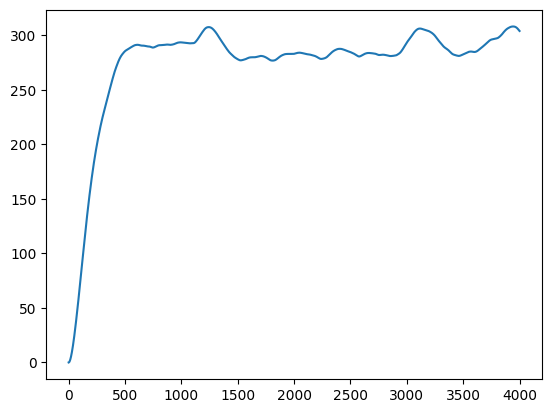

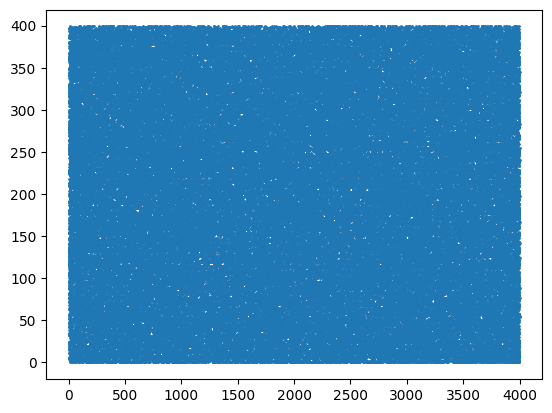

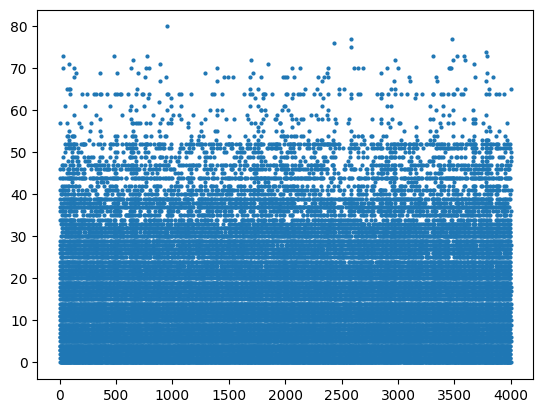

valor: 200


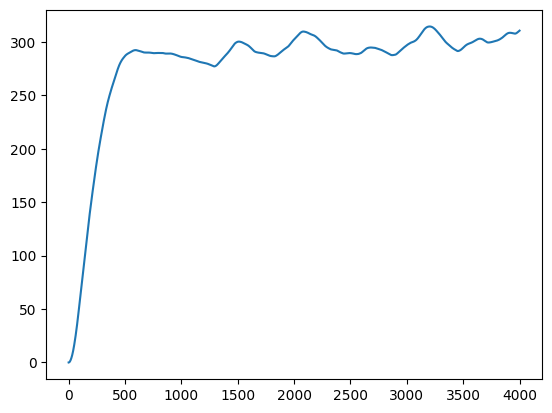

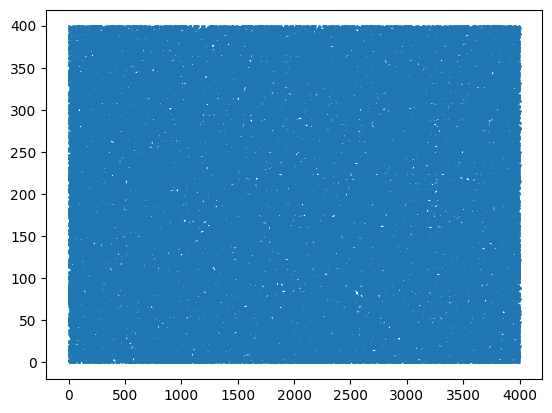

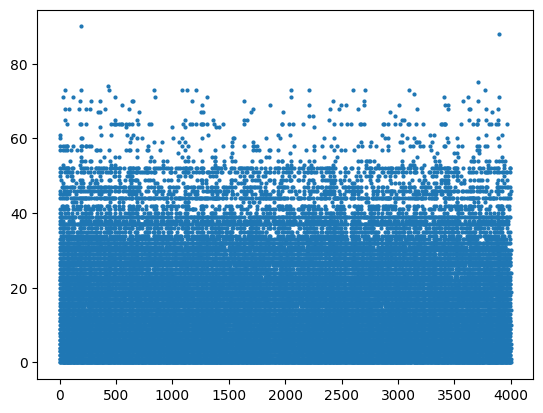

valor: 300


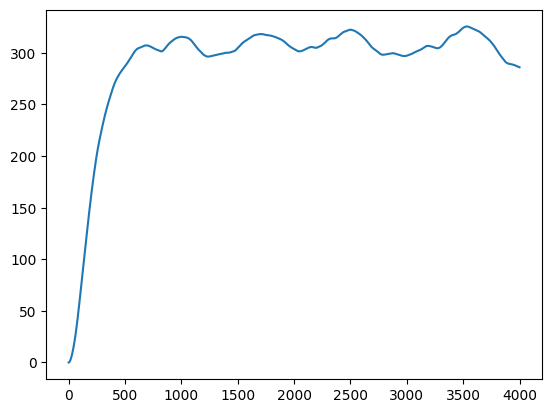

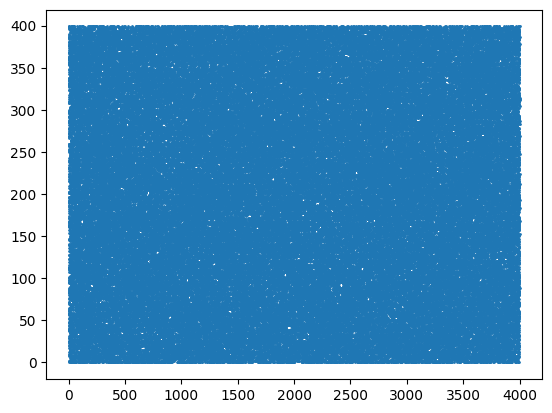

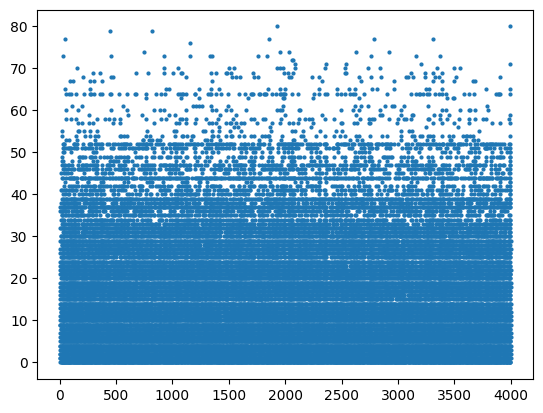

valor: 400


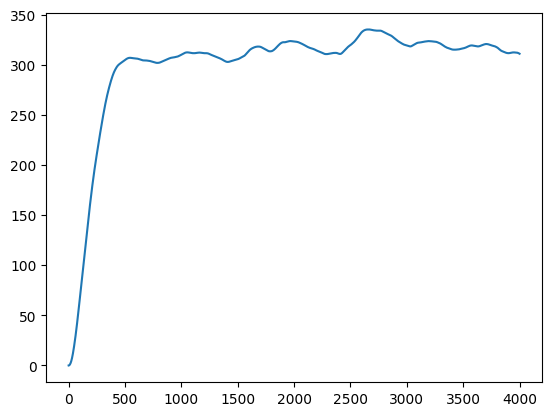

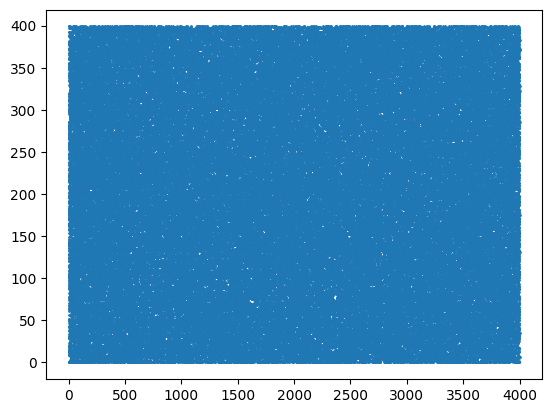

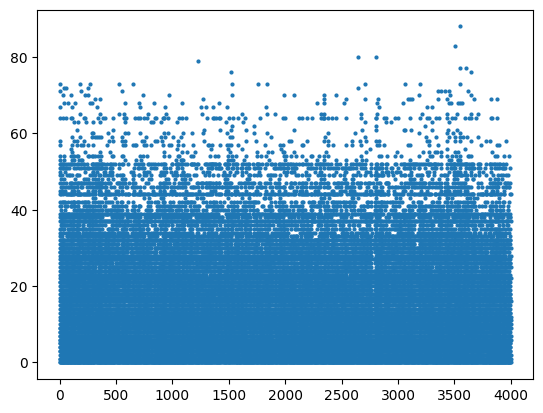

valor: 500


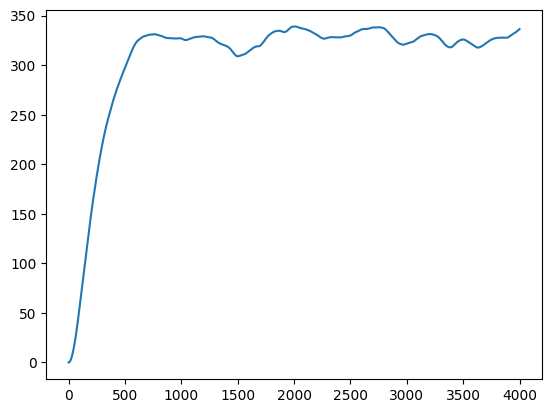

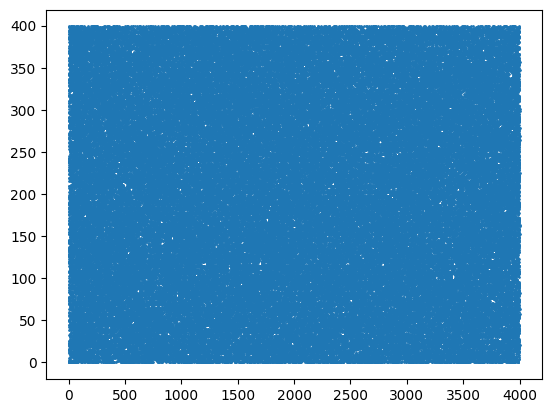

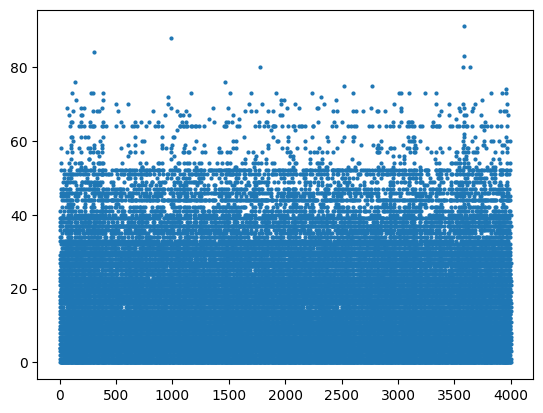

valor: 600


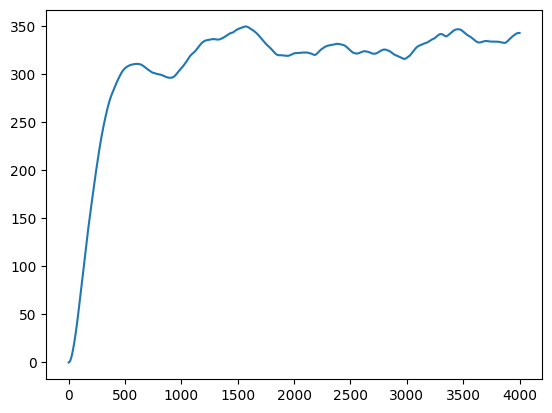

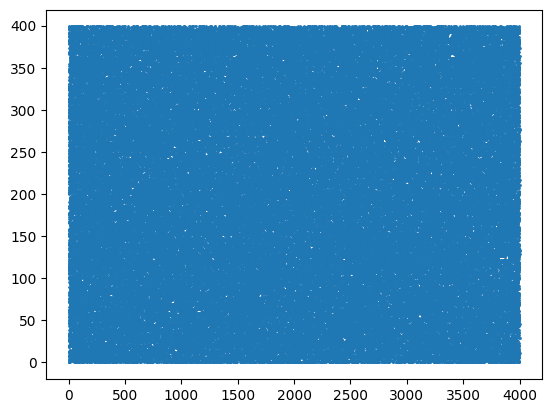

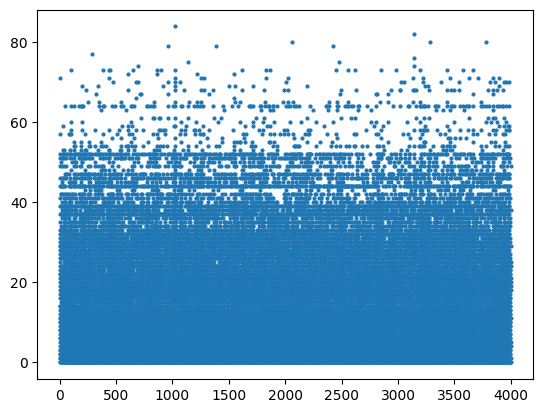

valor: 700


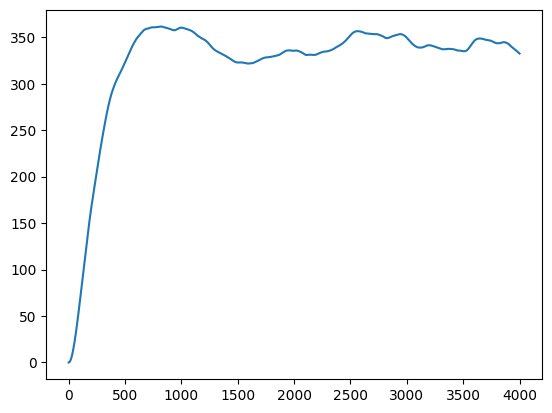

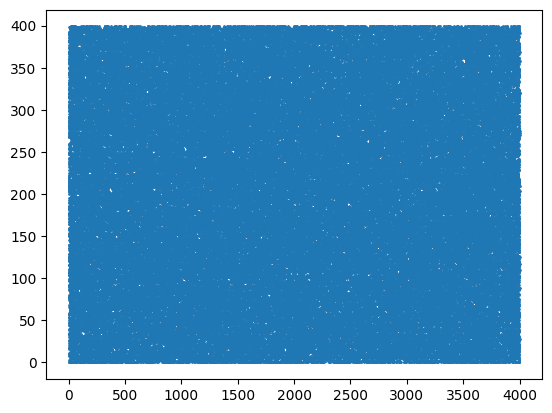

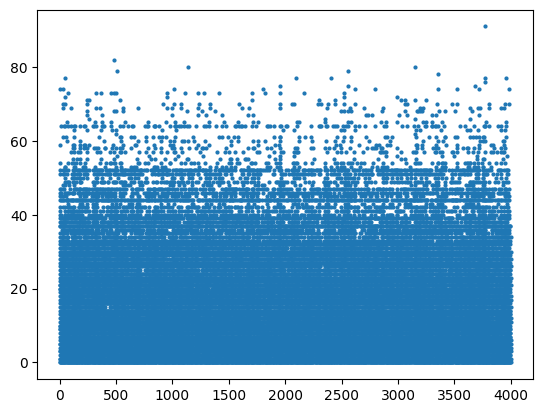

valor: 800


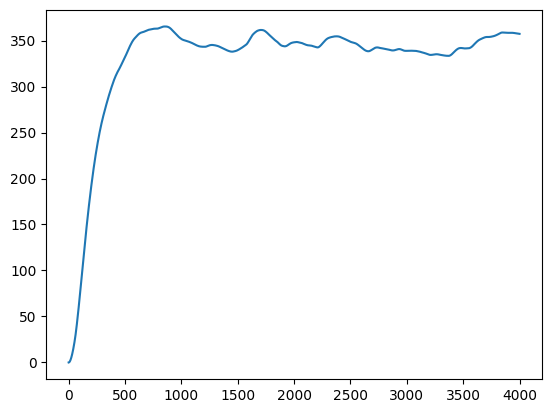

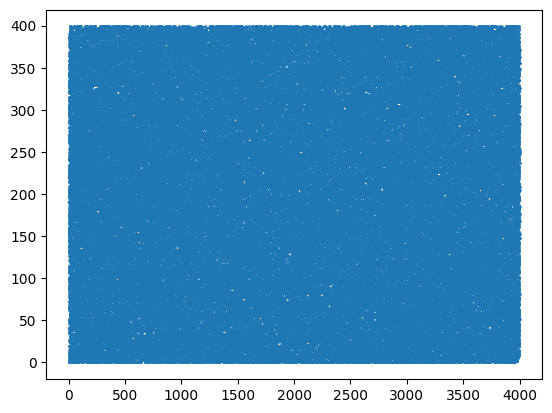

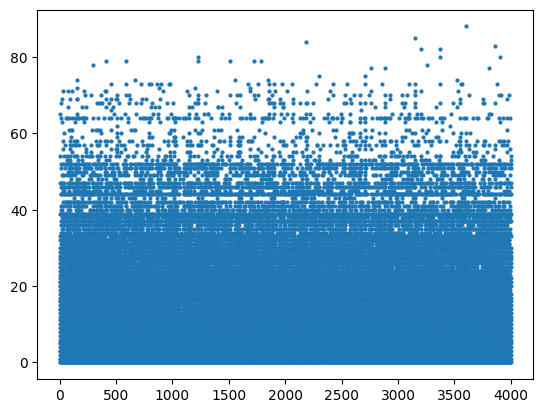

valor: 900


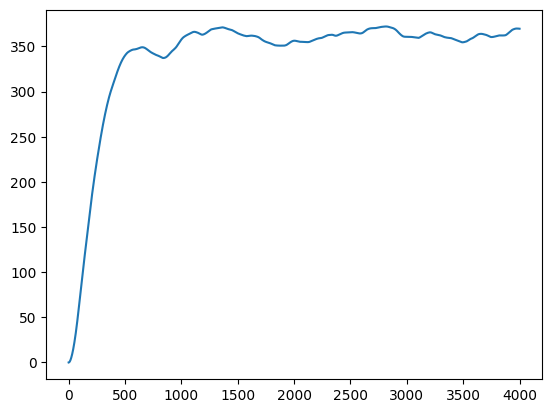

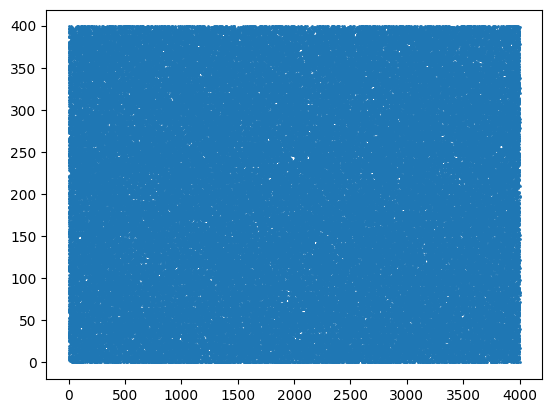

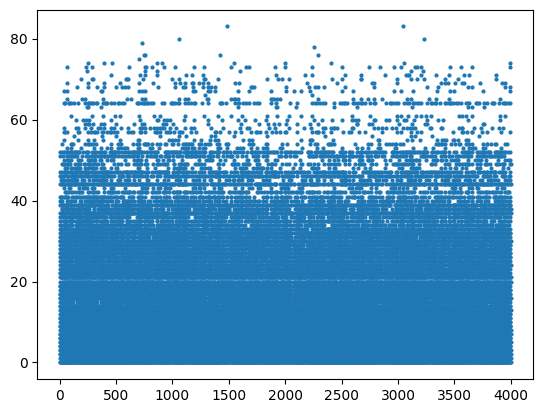

valor: 1000


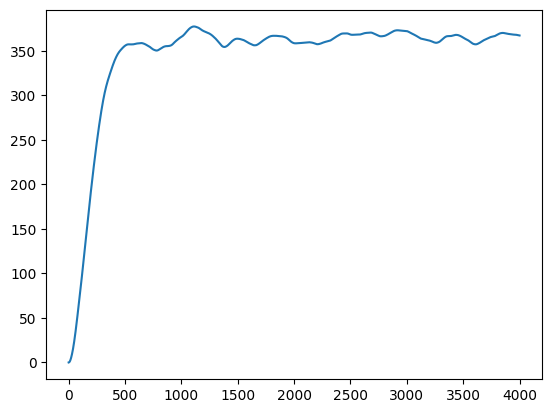

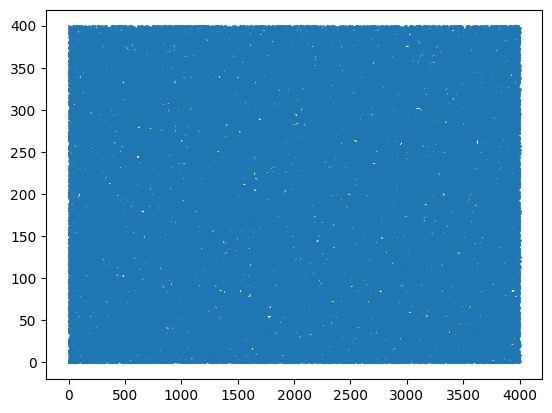

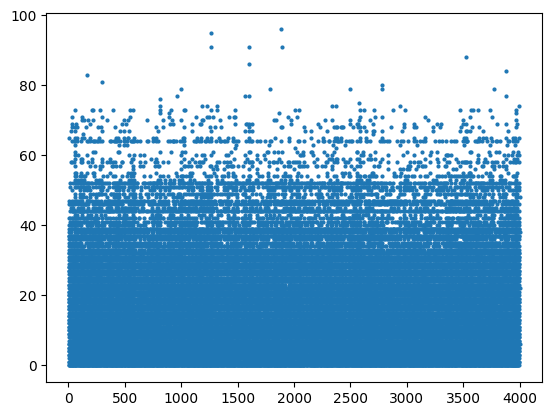

In [5]:


refs = [100, 200,300,400,500,600,700,800,900,1000]  
n= 0
for ref in refs:
    Tf = 4000
    timestep = 0.05
    sim.run(Tf, callbacks=[Classes.SetRate(spike_source, cells, force_objects, ref=ref)])
    
    #teste força
    força_total = soma_força(force_objects, h, f).as_numpy()
    rate = 83 + ((ref - força_total) * 0.01)
    t = np.arange(0, Tf + timestep, timestep)
    plt.plot(np.arange(0, Tf+timestep, timestep), força_total)
    plt.show()
    
    new_folder = "força.Umax=2000"
    os.makedirs(new_folder, exist_ok=True)
    df = pd.DataFrame({'time': t, 'força_total': força_total, 'rate': rate})
    filename = os.path.join(new_folder, f'Ca_forca_ref{ref}_Umax=2000.csv')
    df.to_csv(filename, index=False) 
    
    data_source = spike_source.get_data().segments[n]
    data = cells.get_data().segments[n]
    
    #teste spike_datasource
    spike_df = pd.DataFrame([{"neuron_id": neuron_id, "spike_time": spike_time}
        for neuron_id, spikes in enumerate(data_source.spiketrains)
        for spike_time in spikes])
    
    new_folder1 = "spikedatasource.Umax=2000"
    os.makedirs(new_folder1, exist_ok=True)    
    filename = os.path.join(new_folder1, f'Ca_spike_data_ref_{ref}_Umax=2000.csv')
    spike_df.to_csv(filename, index=False)
    
    plt.scatter(spike_df["spike_time"], spike_df["neuron_id"], s=4, label=f"ref={ref}")
    plt.show()
    
    #teste spike_data
    cell_spike_df = pd.DataFrame([{"neuron_id": neuron_id, "spike_time": spike_time}
        for neuron_id, spikes in enumerate(data.spiketrains)
        for spike_time in spikes])
    
    new_folder2 = "spikedata.Umax=2000"
    os.makedirs(new_folder2, exist_ok=True)    
    filename = os.path.join(new_folder2, f'Ca_cell_spike_ref_{ref}_Umax=2000.csv')
    cell_spike_df.to_csv(filename, index=False)
    
    plt.scatter(cell_spike_df["spike_time"], cell_spike_df["neuron_id"], s=4,label=f"ref={ref}")
    plt.show()
    sim.reset()
    n = n+1